In [1]:
import sys

# execution env
sys.executable

'/usr/local/anaconda3/envs/torch-nlp/bin/python3'

In [2]:
import warnings
import time

import numpy as np

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [3]:
import os

# add module
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from translators.utils.constants import Constants
from translators.datasets.translation_dataset import TranslationDataset

from translators.networks.encoder import Encoder
from translators.networks.decoder import Decoder

In [5]:
# device
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# dataset
dataset = TranslationDataset("de_core_news_sm", "en_core_web_sm")
train_loader, (source_vocab, target_vocab) = dataset.load("train", 32, current_device)
len(source_vocab), len(target_vocab)

(19215, 10838)

In [7]:
# special tokens
source_vocab.get_itos()[:4], target_vocab.get_itos()[:4]

(['<unk>', '<pad>', '<bos>', '<eos>'], ['<unk>', '<pad>', '<bos>', '<eos>'])

In [8]:
bos_tok_id = source_vocab.get_stoi()[Constants.SPECIAL_TOKEN_BOS]

In [9]:
def plot_network_layer(layer_name: str, layer_output: torch.Tensor):
    # setup
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={
        "grid.linewidth": 0.2, 
        "axes.titlesize": 8,
        "axes.labelsize": 8
    })

    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

    # plt
    ax_0 = ax if not hasattr(ax, '__iter__') else ax[0]
    ax_0.set_title(layer_name)
    sns.kdeplot(data=layer_output.flatten().detach().numpy(), color="darkblue", fill=False, ax=ax_0, linewidth=1)

    # display
    plt.tight_layout()
    plt.show()
    pass

In [10]:
# encoder configs
enc_embedding_dim = 256
enc_lstm_layers = 4
enc_lstm_hidden_dim = 256
enc_bidirec = True
enc_dropout_p = 0.025

# decoder configs
dec_embedding_dim = 256

# init encoder
enc = Encoder(
    vocab_size=len(source_vocab.get_itos()),
    embedding_dim=enc_embedding_dim, 
    lstm_num_layers=enc_lstm_layers, 
    lstm_hidden_dim=enc_lstm_hidden_dim, 
    lstm_bidirec=enc_bidirec, 
    dropout_p=enc_dropout_p
)

# init decoder
dec = Decoder(
    vocab_size=len(target_vocab.get_itos()),
    embedding_dim=dec_embedding_dim,
    enc_lstm_hidden_dim=enc_lstm_hidden_dim,
    enc_lstm_bidirec=enc_bidirec,
    enc_lstm_layers=enc_lstm_layers,
    bos_tok_id=source_vocab.get_stoi()[Constants.SPECIAL_TOKEN_BOS],
    use_stepwise_ctxt=True
)

In [11]:
for i, (s, t) in enumerate(train_loader):
    source_sample, target_sample = s, t
    break

In [14]:
# enc forward
enc_lstm_hidden, enc_lstm_ctxt, enc_layer_outputs = enc(
    source_batch=source_sample
)

# dec forward
dec_logits, dec_layer_outputs = dec(
    enc_lstm_hidden=enc_lstm_hidden, 
    enc_lstm_ctxt=enc_lstm_ctxt, 
    use_teacher_forcing=True, 
    minibatch_target=target_sample
)

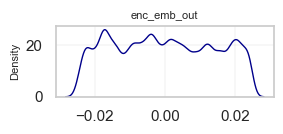

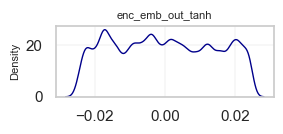

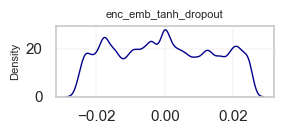

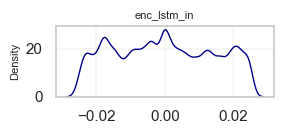

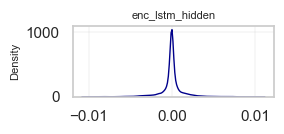

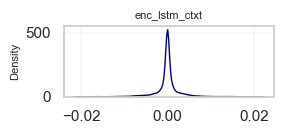

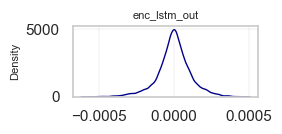

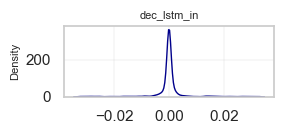

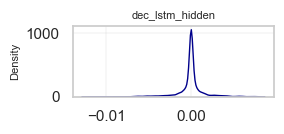

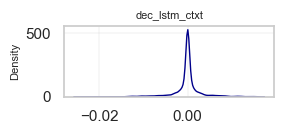

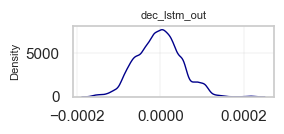

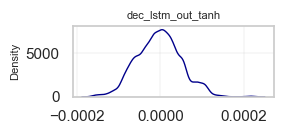

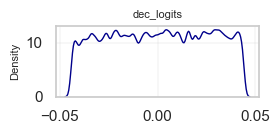

In [15]:
# encoder layers
for l_name in list(enc_layer_outputs.keys()):
    l_out = enc_layer_outputs[l_name]
    plot_network_layer(f"enc_{l_name}", l_out)
    pass

# decoder layers
for l_name in list(dec_layer_outputs.keys()):
    l_out = dec_layer_outputs[l_name]
    plot_network_layer(f"dec_{l_name}", l_out)
    pass

In [17]:
# training setup
torch.enable_grad()
train_loss_i = list()
train_loader, (source_vocab, target_vocab) = dataset.load("train", 256, current_device)

In [26]:
# opt / lr
enc_opt = torch.optim.AdamW(enc.parameters(), lr = 1e-3)
dec_opt = torch.optim.AdamW(dec.parameters(), lr = 1e-3)
loss_function = nn.NLLLoss()

In [ ]:
# training loop
for e in range(100):
    print(f"*** epoch {e} ***")
    for i, batch in enumerate(train_loader):     
        b_source, b_target = batch
        
        lstm_hidden, lstm_ctxt, _ = enc(b_source)
        logits, _ = dec(lstm_hidden, lstm_ctxt, use_teacher_forcing=True, minibatch_target=b_target)
        log_probs = F.log_softmax(logits, dim=-1)

        # zero grads
        enc.zero_grad(set_to_none=True)
        dec.zero_grad(set_to_none=True)
    
        # loss
        loss = loss_function(
            log_probs.view(-1, log_probs.size(-1)),
            b_target.view(-1)
        )

        # backprop
        loss.backward()
        enc_opt.step()
        dec_opt.step()

        # track
        train_loss_i.append(round(loss.item(), 2))

        if i % 5 == 0:
            print(np.mean(train_loss_i[-5:]))
            pass

*** epoch 0 ***
5.882
3.6159999999999997
2.9560000000000004
2.858
2.846
2.68
2.6660000000000004
2.874
2.6759999999999997
2.5799999999999996
2.478
2.318
2.6919999999999997
2.59
2.474
2.498


In [ ]:
# plot
plt.plot(train_loss_i)

In [74]:
def run_inference(b_source_i, b_target_i):
    # eval
    enc.eval()
    dec.eval()

    with torch.no_grad():
        source_words = []
        for tok_idx in b_source_i.squeeze().tolist():
            source_words.append(source_vocab.get_itos()[tok_idx])
            pass

        print("source: ", " ".join(source_words))

        source_str = b_source_i.unsqueeze(0)
        target_str = b_target_i.unsqueeze(0)

        lstm_hidden, lstm_ctxt, _ = enc(source_str)
        logits, _ = dec(lstm_hidden, lstm_ctxt)
        log_probs = F.log_softmax(logits, dim=-1)
        next_tok = torch.multinomial(log_probs, num_samples=1)
        decoded_toks = next_tok.squeeze().tolist()

        decoded_words = []
        for tok_idx in decoded_toks:
            decoded_words.append(target_vocab.get_itos()[tok_idx])
            pass

        print("target: ", " ".join(decoded_words), "\n")
        pass
    
    # train
    enc.train()
    dec.train()
    pass

In [84]:
inf_sample_idx = 5
run_inference(b_source[inf_sample_idx], b_target[inf_sample_idx].unsqueeze(0))

source:  <bos> Eine ältere Frau , eine jüngere Frau , ein kleiner Junge und ein schwarzer Hund gehen auf einem Waldweg spazieren . 
 <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
target:  <bos> <bos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 



In [ ]:
# @todo write minibatch code, replace mocks with actual data [x].
# @todo compute negative log likelihood loss [x]
# @todo verify that backprop is training
# @todo decouple loss computation & sequence generation
# @todo update teacher forcing
# @todo write inference code
# @todo move computation to gpus
# @todo train partially, check that output improves
# @todo make code modular
# @todo integrate wandb, train